# Required libraries

In [1]:
# Required libraries
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

# hana-ml classes
from hana_ml import ConnectionContext
from hana_ml.dataframe import create_dataframe_from_pandas, DataFrame
from hana_ml.algorithms.pal.preprocessing import IsolationForest

# --- Connection Setup (Replace with your actual credentials) ---
# Please ensure these environment variables are set or replace the strings directly.
hana_address = os.getenv('hana_address', "<your_hana_address>")
hana_port = int(os.getenv('hana_port', 443)) # Use int() for port
hana_user = os.getenv('hana_user', "<your_hana_user>")
hana_password = os.getenv('hana_password', "<your_hana_password>")
hana_encrypt = os.getenv('hana_encrypt', 'true').lower() == 'true' # Handle boolean conversion
hana_schema = os.getenv('HANA_SCHEMA', 'AICOE') # Default schema or your specific one

# Establish connection
try:
    cc = ConnectionContext(
        address=hana_address,
        port=hana_port,
        user=hana_user,
        password=hana_password,
        encrypt=hana_encrypt,
        # Add sslValidateCertificate='false' if using self-signed certs and encryption
        # sslValidateCertificate='false',
        current_schema=hana_schema # Set the schema context
    )
    print(f"HANA Connection Test Successful: {cc.hana_version()}")
    print(f"Current Schema: {cc.get_current_schema()}")
except Exception as e:
    print(f"Error connecting to HANA: {e}")
    # Stop execution if connection fails
    raise SystemExit("HANA connection failed, please check credentials and settings.")

# --- Configuration for the Notebook ---
# Name for the HANA table we will create
TABLE_NAME = "SYNTHETIC_ANOMALY_DATA_IFOREST"
# Path to the generated data file
CSV_FILENAME = 'synthetic_anomaly_data.csv'
# Unique identifier column for HANA PAL functions
KEY_COL = 'ID'
# Ground truth column from the generator script
TRUTH_COL = 'is_anomaly'

ImportError: cannot import name 'display' from 'IPython.core.display' (/Users/I760054/Documents/programs/Best Practices/sap-btp-ai-best-practices/.venv/lib/python3.12/site-packages/IPython/core/display.py)


HANA Connection Test Successful: 4.00.000.00.1733217781 (fa/CE2024.28)
Current Schema: AICOE


# Isolation Forest with hana-ml

**Objective:** This notebook demonstrates how to use the `IsolationForest` algorithm provided by the SAP HANA Predictive Analysis Library (PAL) via the `hana-ml` Python client. We will perform anomaly detection on a synthetically generated dataset.

**Algorithm Overview:**
Isolation Forest is an unsupervised anomaly detection algorithm. It works by randomly partitioning the data space and isolating observations. The core idea is that anomalies are "few and different," making them easier to isolate compared to normal points. Points that require fewer random partitions to be isolated are considered more likely to be anomalies and receive a lower anomaly score.

**`hana_ml` Implementation:**
The `hana_ml.algorithms.pal.preprocessing.IsolationForest` class (more documentation available [here](https://help.sap.com/doc/1d0ebfe5e8dd44d09606814d83308d4b/2.0.07/en-US/pal/algorithms/hana_ml.algorithms.pal.preprocessing.IsolationForest.html#hana_ml.algorithms.pal.preprocessing.IsolationForest)) provides an interface to the PAL Isolation Forest function.

**Key Parameters (`IsolationForest` constructor):**

*   `n_estimators` (int, optional, default=100): Number of isolation trees to build in the forest. More trees generally lead to better performance but increase computation time.
*   `max_samples` (int, optional, default=256): Number of samples to draw from the input data to train each individual tree. If the dataset size is smaller than `max_samples`, all samples are used. Sub-sampling makes the algorithm more robust to large datasets and speeds up training.
*   `max_features` (int, optional, default=0): Number of features to draw from the input to train each tree. If 0, all features are used. Feature sub-sampling can sometimes improve performance, especially with high-dimensional data.
*   `bootstrap` (bool, optional, default=False): Specifies the sampling method for `max_samples`.
    *   `False`: Sampling without replacement.
    *   `True`: Sampling with replacement.
*   `random_state` (int, optional, default=0): Seed for the random number generator used for sample and feature selection. Use 0 for time-based seed, or any other integer for a reproducible seed.
*   `thread_ratio` (float, optional, default=-1.0): Controls the percentage of available CPU threads PAL can use (0.0 to 1.0). 0 means single-threaded, 1 means use all available threads. -1 lets PAL heuristically decide.
*   `massive` (bool, optional, default=False): Enables massive mode, useful for very large datasets where data might need to be processed in groups (often related to partitioning in HANA). Requires `group_key` and potentially `group_params` if different settings are needed per group.
*   `group_params` (dict, optional, default=None): Used only when `massive=True`. A dictionary where keys correspond to values in the `group_key` column, and values are dictionaries specifying parameters (`n_estimators`, `max_samples`, etc.) specific to that group.

## 1. Data Loading and Preparation

First, we load the synthetic data generated by `anomaly_generator.py` into a pandas DataFrame and then upload it to SAP HANA.

In [2]:
# Load data from CSV
try:
    df_local = pd.read_csv(CSV_FILENAME)
    print(f"Successfully loaded '{CSV_FILENAME}' with shape {df_local.shape}")
except FileNotFoundError:
    print(f"Error: The file '{CSV_FILENAME}' was not found.")
    print("Please run the 'anomaly_generator.py' script first to create the data.")
    # Stop execution
    raise SystemExit("Input data file not found.")

# Add a unique ID column required by many PAL functions
if KEY_COL not in df_local.columns:
    df_local.insert(0, KEY_COL, range(len(df_local)))
    print(f"Added unique '{KEY_COL}' column.")

# Identify feature columns (assuming they start with 'feature_')
feature_cols = [col for col in df_local.columns if col.startswith('feature_')]
if not feature_cols:
     raise ValueError("No columns starting with 'feature_' found. Check data generation script or naming.")
print(f"Identified Feature Columns: {feature_cols}")

# Display basic info and head of the local DataFrame
print("\nLocal DataFrame Info:")
df_local.info()
print("\nLocal DataFrame Head:")
print(df_local.head())
print("\nAnomaly Distribution (Ground Truth):")
print(df_local[TRUTH_COL].value_counts(normalize=True))

# Calculate the actual contamination level from the ground truth
actual_contamination = df_local[TRUTH_COL].mean()
print(f"\nActual contamination in the dataset: {actual_contamination:.4f}")

# --- Upload data to HANA ---
# Drop the table if it exists before creating a new one
try:
    cc.drop_table(TABLE_NAME)
    print(f"Dropped existing table '{TABLE_NAME}' (if any).")
except Exception:
    print(f"Table '{TABLE_NAME}' does not exist yet, proceeding.")

# Create HANA DataFrame from pandas DataFrame
print(f"\nUploading data to HANA table '{TABLE_NAME}'...")
try:
    # Using force=True and replace=True ensures the table matches the pandas DF exactly
    hdf_input = create_dataframe_from_pandas(
        connection_context=cc,
        pandas_df=df_local,
        table_name=TABLE_NAME,
        force=True,
        replace=True,
        primary_key=KEY_COL # Setting primary key can improve performance
    )
    print(f"Successfully created HANA DataFrame: {hdf_input.select(KEY_COL).count()} rows.")
    # Display info about the HANA DataFrame
    print("\nHANA DataFrame Info (selected columns):")
    print(hdf_input.select(KEY_COL, TRUTH_COL, *feature_cols).head(5).collect())

except Exception as e:
    print(f"Error uploading data to HANA: {e}")
    raise SystemExit("Failed to create HANA DataFrame.")

Successfully loaded 'synthetic_anomaly_data.csv' with shape (1050, 6)
Added unique 'ID' column.
Identified Feature Columns: ['feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5']

Local DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ID          1050 non-null   int64  
 1   feature_1   1050 non-null   float64
 2   feature_2   1050 non-null   float64
 3   feature_3   1050 non-null   float64
 4   feature_4   1050 non-null   float64
 5   feature_5   1050 non-null   float64
 6   is_anomaly  1050 non-null   int64  
dtypes: float64(5), int64(2)
memory usage: 57.6 KB

Local DataFrame Head:
   ID  feature_1  feature_2  feature_3  feature_4  feature_5  is_anomaly
0   0  18.277572  48.592749  43.922557  42.893798  13.340332           0
1   1  22.595480  45.241644  34.772461  29.038658  15.248534           0
2   2  20.127974  4

ERROR:hana_ml.dataframe:Fail to drop table. (259, 'invalid table name: SYNTHETIC_ANOMALY_DATA_IFOREST: line 1 col 20 (at pos 19)')


Dropped existing table 'SYNTHETIC_ANOMALY_DATA_IFOREST' (if any).

Uploading data to HANA table 'SYNTHETIC_ANOMALY_DATA_IFOREST'...


100%|██████████| 1/1 [00:00<00:00,  9.28it/s]


Successfully created HANA DataFrame: 1050 rows.

HANA DataFrame Info (selected columns):
   ID  is_anomaly  feature_1  feature_2  feature_3  feature_4  feature_5
0   0           0  18.277572  48.592749  43.922557  42.893798  13.340332
1   1           0  22.595480  45.241644  34.772461  29.038658  15.248534
2   2           0  20.127974  48.403411  23.545939  33.311360  -2.885488
3   3           0  16.412641  45.087063  47.438820  31.308031  26.548545
4   4           0  17.728823  47.785572  29.888634  17.650589  -1.527156


## 2. Training the Isolation Forest Model

Now, we instantiate the `IsolationForest` class from `hana-ml` and train it using the `fit()` method on our HANA DataFrame.

In [3]:
# Instantiate the Isolation Forest model
# We use the actual contamination calculated earlier for the predict step later.
# Let's start with some reasonable parameters.
iforest = IsolationForest(
    n_estimators=100,      # Number of trees
    max_samples=256,       # Samples per tree (default)
    random_state=42,       # For reproducibility within PAL execution
    thread_ratio=-1       # Let's make PAL decide the number of threads
    # We are not using massive mode for this example initially
)

print("Isolation Forest model instantiated:")
print(iforest)

# Train the model
# The fit method only requires the data, key, and features.
# It does not use contamination during training.
print("\nTraining the Isolation Forest model...")
try:
    # Fit the model to the data in HANA
    iforest.fit(data=hdf_input, key=KEY_COL, features=feature_cols)
    print("Model training completed successfully.")
except Exception as e:
    print(f"Error during model training: {e}")
    raise SystemExit("Model training failed.")

# The trained model information is stored internally and referenced by the object.
# You can inspect the generated PAL tables via the model_ attribute (less common for direct use)
# print("\nPAL Model Tables (Content):")
# if hasattr(iforest, 'model_') and iforest.model_:
#     print(iforest.model_.collect())
# else:
#     print("Model content table not available or not generated by fit.")


Isolation Forest model instantiated:

Training the Isolation Forest model...
Model training completed successfully.


## 3. Predicting Anomalies

With the trained model, we can now use the `predict()` method to obtain anomaly scores and labels for our data points.

**Key Parameters (`predict` method):**

*   `data` (DataFrame): The HANA DataFrame containing the data to score. Can be the same as training data or new data.
*   `key` (str): The name of the ID column in the `data` DataFrame.
*   `features` (list of str, optional): List of feature columns to use for prediction. If None, uses the same features as during `fit`.
*   `contamination` (float, optional, default=0.1): The expected proportion of outliers in the dataset. This value acts as a threshold on the raw anomaly scores to assign labels (-1 for outlier, 1 for inlier). It should be in the range (0, 0.5].
*   `thread_ratio` (float, optional): Overrides the `thread_ratio` set during instantiation for the prediction step.
*   `group_key`, `group_params`: Used for massive mode prediction.

In [4]:
# Predict anomaly scores and labels
# We use the 'actual_contamination' calculated from the ground truth for thresholding.
# In a real scenario without ground truth, you might estimate this based on domain knowledge
# or use the default (0.1).
print(f"\nPredicting anomalies using contamination = {actual_contamination:.4f}...")

try:
    # The predict method returns a tuple: (results_dataframe, error_dataframe)
    # For non-massive mode, the error dataframe is usually None or empty.
    results_hdf = iforest.predict(
        data=hdf_input,
        key=KEY_COL,
        contamination=float(actual_contamination)  # Convert to float if necessary
    )

    print("Prediction completed.")

    # Check the results DataFrame
    if results_hdf:
        print("\nPrediction Results (HANA DataFrame Head):")
        # Collect results into a pandas DataFrame for analysis
        df_results = results_hdf.collect()
        print(df_results.head())

        print("\nPrediction Results Info:")
        df_results.info()

        # Check the structure of the output: ID, SCORE, LABEL
        # SCORE: Lower scores indicate higher likelihood of being an anomaly.
        # LABEL: -1 indicates anomaly, 1 indicates inlier (based on contamination threshold).

    else:
        print("Prediction did not return a results DataFrame.")


except Exception as e:
    print(f"Error during prediction: {e}")
    raise SystemExit("Prediction failed.")


Predicting anomalies using contamination = 0.0476...
Prediction completed.

Prediction Results (HANA DataFrame Head):
   ID     SCORE  LABEL
0   0  0.380766      1
1   1  0.392376      1
2   2  0.410603      1
3   3  0.410466      1
4   4  0.388289      1

Prediction Results Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ID      1050 non-null   int64  
 1   SCORE   1050 non-null   float64
 2   LABEL   1050 non-null   int64  
dtypes: float64(1), int64(2)
memory usage: 24.7 KB


## 4. Evaluating the Results

Since our synthetic dataset includes ground truth labels (`is_anomaly`), we can evaluate the performance of the Isolation Forest model. We'll merge the prediction results with the original data (including the truth column) and calculate some common metrics.


Merging predictions with ground truth...

Merged DataFrame Head (with truth and prediction):
   ID  is_anomaly     SCORE  LABEL  predicted_anomaly
0   0           0  0.380766      1                  0
1   1           0  0.392376      1                  0
2   2           0  0.410603      1                  0
3   3           0  0.410466      1                  0
4   4           0  0.388289      1                  0

--- Classification Report ---
              precision    recall  f1-score   support

  Normal (0)       1.00      1.00      1.00      1000
 Anomaly (1)       1.00      1.00      1.00        50

    accuracy                           1.00      1050
   macro avg       1.00      1.00      1.00      1050
weighted avg       1.00      1.00      1.00      1050


--- Confusion Matrix ---
[[1000    0]
 [   0   50]]


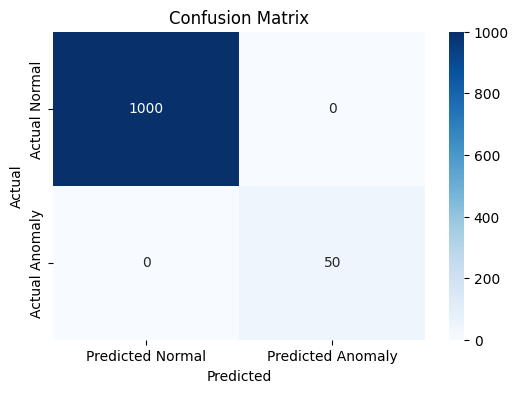

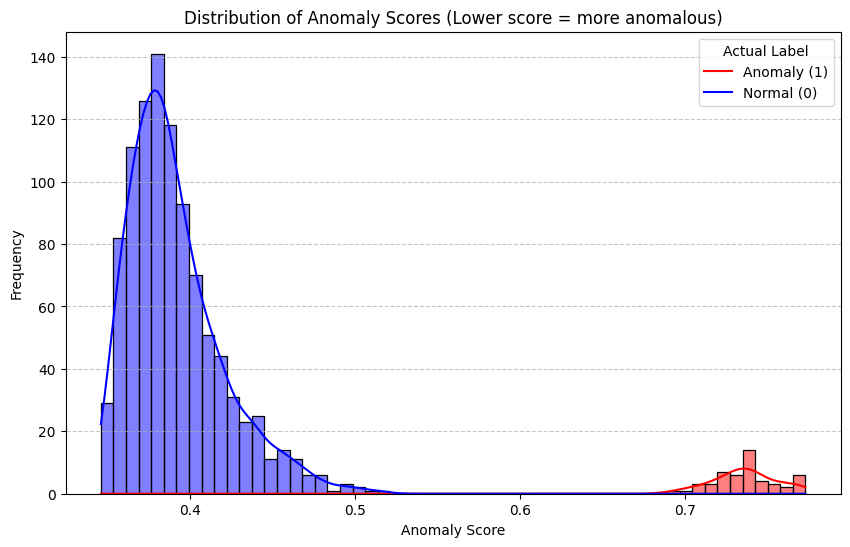

In [5]:
# Ensure we have the results
if 'df_results' not in locals() or df_results is None:
     raise SystemExit("Prediction results are not available for evaluation.")

# Merge predictions with the original local data (which has the ground truth)
print("\nMerging predictions with ground truth...")
df_merged = pd.merge(df_local[[KEY_COL, TRUTH_COL]], df_results, on=KEY_COL)

# The model's LABEL is -1 for outliers and 1 for inliers.
# Our ground truth TRUTH_COL is 1 for anomalies (outliers) and 0 for normal (inliers).
# We need to map the predicted LABEL to match the ground truth format for comparison.
df_merged['predicted_anomaly'] = df_merged['LABEL'].apply(lambda x: 1 if x == -1 else 0)

print("\nMerged DataFrame Head (with truth and prediction):")
print(df_merged[[KEY_COL, TRUTH_COL, 'SCORE', 'LABEL', 'predicted_anomaly']].head())

# --- Performance Metrics ---
print("\n--- Classification Report ---")
# Compare ground truth (is_anomaly) with the mapped prediction (predicted_anomaly)
print(classification_report(df_merged[TRUTH_COL], df_merged['predicted_anomaly'], target_names=['Normal (0)', 'Anomaly (1)']))

print("\n--- Confusion Matrix ---")
cm = confusion_matrix(df_merged[TRUTH_COL], df_merged['predicted_anomaly'])
print(cm)
# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Normal', 'Predicted Anomaly'], yticklabels=['Actual Normal', 'Actual Anomaly'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


# --- Score Distribution ---
# Visualize the distribution of anomaly scores for actual normal vs. actual anomaly points
plt.figure(figsize=(10, 6))
sns.histplot(data=df_merged, x='SCORE', hue=TRUTH_COL, kde=True, palette={0: 'blue', 1: 'red'})
plt.title('Distribution of Anomaly Scores (Lower score = more anomalous)')
plt.xlabel('Anomaly Score')
plt.ylabel('Frequency')
# Add legend manually if needed or rely on seaborn's default
plt.legend(title='Actual Label', labels=['Anomaly (1)', 'Normal (0)']) # Adjust labels based on plot order if necessary
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()



--- Visualizing Predictions vs. Ground Truth ---

Generating pair plot for prediction analysis...


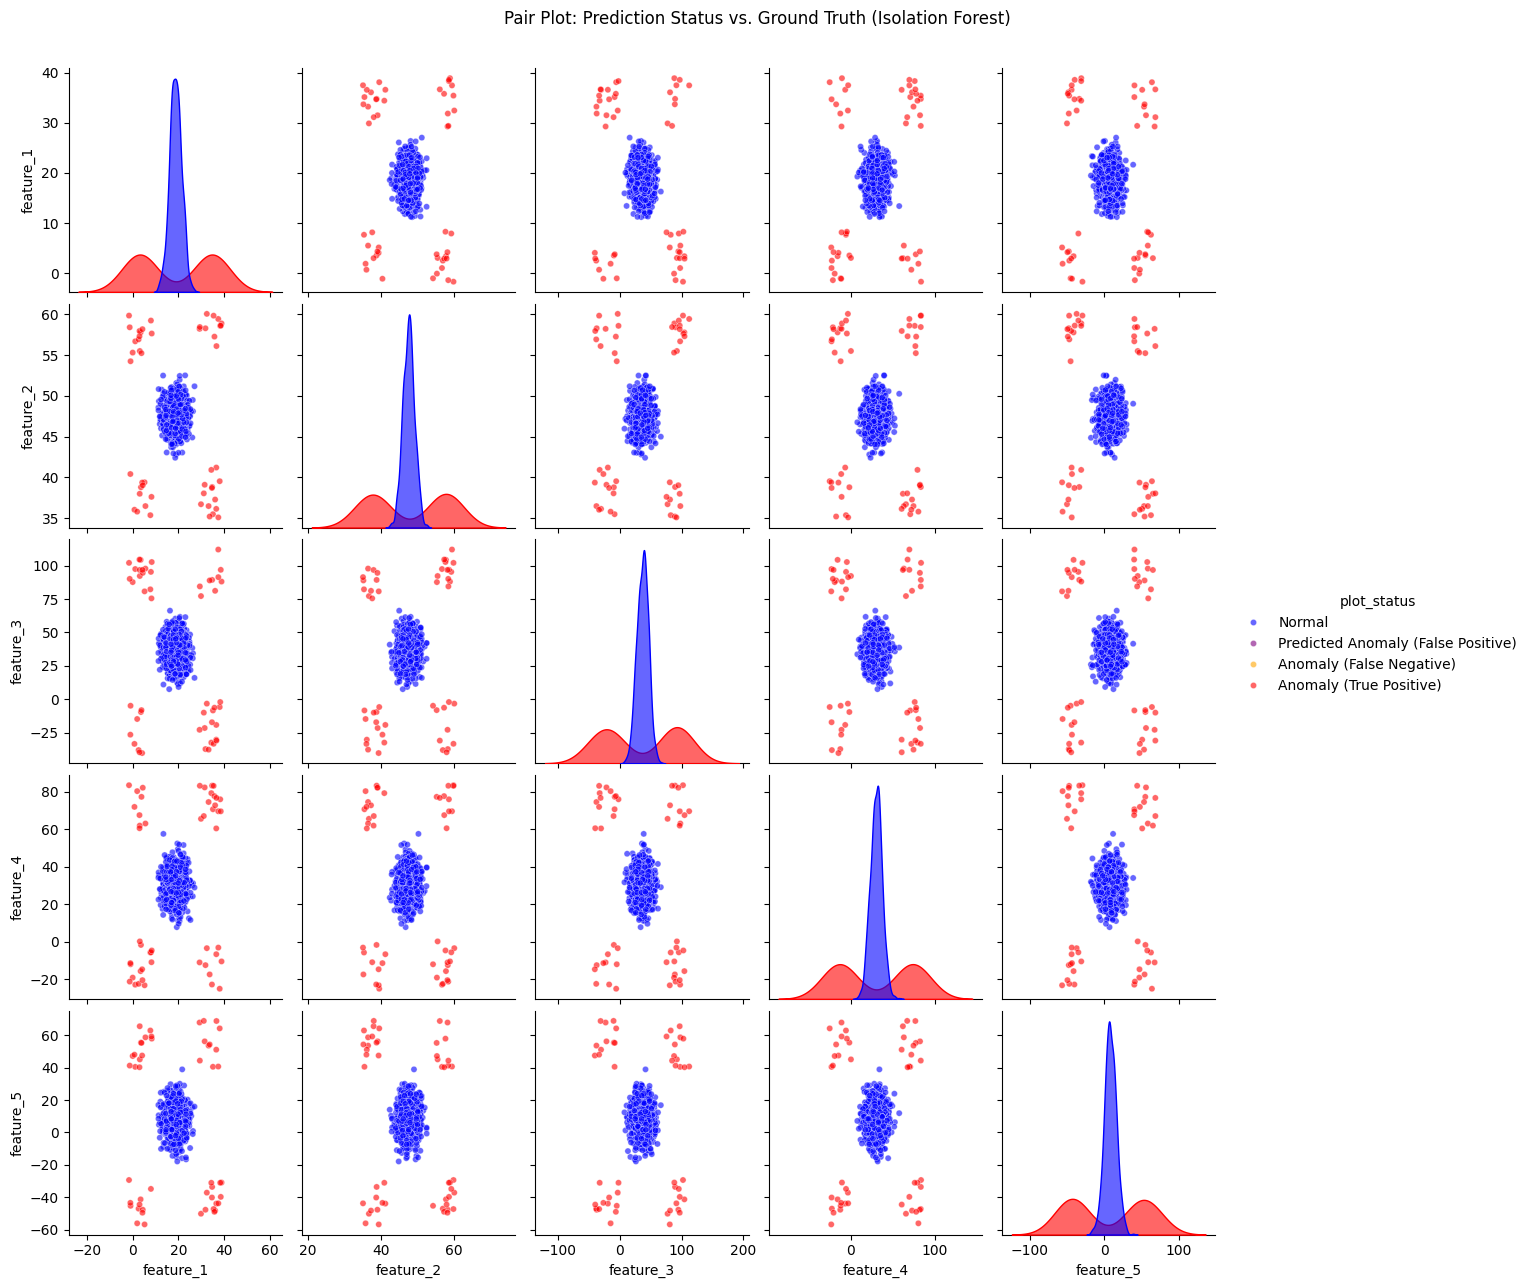

In [6]:
# --- Prediction Visualization (Pair Plot) ---
print("\n--- Visualizing Predictions vs. Ground Truth ---")

# Define a function to map status based on truth and prediction
def assign_plot_status(row):
    if row[TRUTH_COL] == 0 and row['predicted_anomaly'] == 0:
        return 'Normal'
    elif row[TRUTH_COL] == 1 and row['predicted_anomaly'] == 1:
        return 'Anomaly (True Positive)'
    elif row[TRUTH_COL] == 1 and row['predicted_anomaly'] == 0:
        return 'Anomaly (False Negative)' # Missed by model
    elif row[TRUTH_COL] == 0 and row['predicted_anomaly'] == 1:
        return 'Predicted Anomaly (False Positive)' # Incorrectly flagged
    else:
        return 'Unknown'

# Apply the function to create the status column in the merged dataframe
df_merged['plot_status'] = df_merged.apply(assign_plot_status, axis=1)

# Add the features from df_local to df_merged
df_merged = df_merged.join(df_local[feature_cols])

# Define a color palette for the statuses
status_palette = {
    'Normal': 'blue',
    'Anomaly (True Positive)': 'red',
    'Anomaly (False Negative)': 'orange',
    'Predicted Anomaly (False Positive)': 'purple'
}

# Generate the pair plot
try:
    print("\nGenerating pair plot for prediction analysis...")
    # Use only feature columns for the plot axes
    pair_plot_preds = sns.pairplot(df_merged, 
                                   vars=feature_cols, 
                                   hue='plot_status', 
                                   palette=status_palette,
                                   diag_kind='kde',
                                   plot_kws={'alpha': 0.6, 's': 20}, 
                                   diag_kws={'alpha': 0.6, 'common_norm': False}, # Use common_norm=False for KDE
                                   hue_order=['Normal', 'Predicted Anomaly (False Positive)', 'Anomaly (False Negative)', 'Anomaly (True Positive)'] # Control legend order
                                  )
    pair_plot_preds.fig.suptitle('Pair Plot: Prediction Status vs. Ground Truth (Isolation Forest)', y=1.03) # Add title
    plt.show()
except Exception as e:
    print(f"\nCould not generate prediction pair plot. Error: {e}")

## 5. Using `fit_predict()`

The `IsolationForest` class also offers a convenience method `fit_predict()` that combines training and prediction in a single step. This is useful if you want to train and score the same dataset simultaneously.

In [7]:
# Instantiate a new model or reuse, but fit_predict will overwrite internal model state
iforest_fp = IsolationForest(
    n_estimators=100,
    max_samples=256,
    random_state=42,
    thread_ratio=0.8
)

print("\nUsing fit_predict()...")

try:
    # fit_predict also takes contamination for thresholding the output labels
    results_fp_hdf = iforest_fp.fit_predict(
        data=hdf_input,
        key=KEY_COL,
        features=feature_cols,
        contamination=float(actual_contamination)  # Ensure contamination is a float
    )

    print("fit_predict completed.")

    if results_fp_hdf:
        print("\nfit_predict Results (HANA DataFrame Head):")
        df_results_fp = results_fp_hdf.collect()
        print(df_results_fp.head())

        # You could perform the same evaluation steps as above on df_results_fp
        # Merging, mapping labels, calculating metrics...
    else:
        print("fit_predict did not return a results DataFrame.")


except Exception as e:
    print(f"Error during fit_predict: {e}")
    raise SystemExit("fit_predict failed.")

# Compare if results from fit() -> predict() are same as fit_predict()
# (Should be identical given same random_state and parameters)
if 'df_results' in locals() and 'df_results_fp' in locals():
     # Sort by ID to ensure correct comparison row-by-row
     df_results_sorted = df_results.sort_values(by=KEY_COL).reset_index(drop=True)
     df_results_fp_sorted = df_results_fp.sort_values(by=KEY_COL).reset_index(drop=True)
     comparison = df_results_sorted.equals(df_results_fp_sorted)
     print(f"\nAre results from predict() and fit_predict() identical? {comparison}")


Using fit_predict()...
fit_predict completed.

fit_predict Results (HANA DataFrame Head):
   ID     SCORE  LABEL
0   0  0.380766      1
1   1  0.392376      1
2   2  0.410603      1
3   3  0.410466      1
4   4  0.388289      1

Are results from predict() and fit_predict() identical? True


## 6. Massive Mode

The `massive=True` parameter is designed for very large datasets,. It requires a `group_key` column in your data. You can apply different Isolation Forest parameters to different groups using `group_params`.

Let's simulate this by adding a group column to our data.

In [8]:
# --- Prepare data for Massive Mode ---
print("\n--- Preparing data for Massive Mode Example ---")
df_local_grouped = df_local.copy()
# Create a group key (e.g., based on ranges of a feature or randomly)
# Example: Create 2 groups randomly
df_local_grouped['GROUP_ID'] = pd.qcut(df_local_grouped[feature_cols[0]], q=2, labels=[1, 2]).astype(int)
print("Added 'GROUP_ID' column:")
print(df_local_grouped[[KEY_COL, 'GROUP_ID'] + feature_cols + [TRUTH_COL]].head())
print("\nGroup Distribution:")
print(df_local_grouped['GROUP_ID'].value_counts())

# Upload grouped data to a new HANA table
TABLE_NAME_MASSIVE = TABLE_NAME + "_MASSIVE"
try:
    cc.drop_table(TABLE_NAME_MASSIVE)
except Exception: pass # Ignore if table doesn't exist

try:
    print(f"\nUploading grouped data to HANA table '{TABLE_NAME_MASSIVE}'...")
    hdf_input_massive = create_dataframe_from_pandas(
        connection_context=cc,
        pandas_df=df_local_grouped,
        table_name=TABLE_NAME_MASSIVE,
        force=True,
        replace=True,
        primary_key=KEY_COL
    )
    print(f"Successfully created HANA DataFrame for massive mode: {hdf_input_massive.select(KEY_COL).count()} rows.")
except Exception as e:
    print(f"Error uploading grouped data to HANA: {e}")
    # Don't stop execution, just skip the massive mode part if upload fails
    hdf_input_massive = None


# --- Run Isolation Forest in Massive Mode ---
if hdf_input_massive:
    # Define different parameters for each group
    # Note: Group keys in group_params MUST match the data type in the group_key column (INT in this case)
    group_settings = {
        1: {'n_estimators': 50, 'max_samples': 128},  # Group 1 settings
        2: {'n_estimators': 150, 'max_samples': 200}   # Group 2 settings
    }

    # General settings apply if not overridden in group_params
    iforest_massive = IsolationForest(
        massive=True,
        group_params=group_settings,
        random_state=42,
        thread_ratio=-1
    )

    print("\nInstantiated Isolation Forest for Massive Mode:")
    print(iforest_massive)

    try:
        print("\nTraining in Massive Mode...")
        # Need to provide group_key during fit
        iforest_massive.fit(
            data=hdf_input_massive,
            key=KEY_COL,
            features=feature_cols,
            group_key='GROUP_ID'
        )
        print("Massive Mode training completed.")

        print("\nPredicting in Massive Mode...")
        # group_key is also needed for predict if the model was trained with it
        # Contamination can be applied globally or potentially specified per group if supported (check docs)
        results_m_hdf = iforest_massive.predict(
            data=hdf_input_massive,
            key=KEY_COL,
            contamination=float(actual_contamination), # Global contamination applied here
            group_key='GROUP_ID'
        )
        print("Massive Mode prediction completed.")
        # First object in tuple results_m_hdf is the DataFrame with predictions, second is collects errors if any
        # Collect the results to a DataFrame
        df_results_m = results_m_hdf[0].collect()
        print("\nMassive Mode Prediction Results (Head):")
        print(df_results_m.head())

    except Exception as e:
        print(f"\nError during Massive Mode execution: {e}")
else:
    print("\nSkipping Massive Mode example due to data upload failure.")


--- Preparing data for Massive Mode Example ---
Added 'GROUP_ID' column:
   ID  GROUP_ID  feature_1  feature_2  feature_3  feature_4  feature_5  \
0   0         1  18.277572  48.592749  43.922557  42.893798  13.340332   
1   1         2  22.595480  45.241644  34.772461  29.038658  15.248534   
2   2         2  20.127974  48.403411  23.545939  33.311360  -2.885488   
3   3         1  16.412641  45.087063  47.438820  31.308031  26.548545   
4   4         1  17.728823  47.785572  29.888634  17.650589  -1.527156   

   is_anomaly  
0           0  
1           0  
2           0  
3           0  
4           0  

Group Distribution:
GROUP_ID
1    525
2    525
Name: count, dtype: int64


ERROR:hana_ml.dataframe:Fail to drop table. (259, 'invalid table name: SYNTHETIC_ANOMALY_DATA_IFOREST_MASSIVE: line 1 col 20 (at pos 19)')



Uploading grouped data to HANA table 'SYNTHETIC_ANOMALY_DATA_IFOREST_MASSIVE'...


100%|██████████| 1/1 [00:00<00:00, 12.36it/s]


Successfully created HANA DataFrame for massive mode: 1050 rows.

Instantiated Isolation Forest for Massive Mode:

Training in Massive Mode...
Massive Mode training completed.

Predicting in Massive Mode...
Massive Mode prediction completed.

Massive Mode Prediction Results (Head):
  GROUP_ID   ID     SCORE  LABEL
0        1  581  0.475863      1
1        1  582  0.454728      1
2        1  583  0.396780      1
3        1  585  0.424514      1
4        1  586  0.728288     -1


## 7. Cleanup

Finally, let's remove the tables we created in HANA.

In [9]:
print("\n--- Cleaning up HANA tables ---")
tables_to_drop = [TABLE_NAME]
if 'TABLE_NAME_MASSIVE' in locals():
    tables_to_drop.append(TABLE_NAME_MASSIVE)
# Add model/result tables if they persist and you know their names (often temporary)

for table in tables_to_drop:
    try:
        cc.drop_table(table)
        print(f"Dropped table: {table}")
    except Exception as e:
        print(f"Could not drop table {table} (may not exist or permissions issue): {e}")

# Close the connection
try:
    cc.close()
    print("\nHANA connection closed.")
except Exception as e:
    print(f"Error closing connection: {e}")


--- Cleaning up HANA tables ---
Dropped table: SYNTHETIC_ANOMALY_DATA_IFOREST
Dropped table: SYNTHETIC_ANOMALY_DATA_IFOREST_MASSIVE

HANA connection closed.
